In [181]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [ ]:
taxi_zones = gpd.read_file('./taxi_zones__7_/taxi_zones.shp')

In [248]:
taxi_zones[taxi_zones['borough'] == 'Manhattan'][['LocationID','borough']].to_csv('TaxiZones_borough.csv')

In [36]:
rides_2019 = pd.read_csv('turnstile_daily_counts_2019.csv')
rides_2020 = pd.read_csv('turnstile_daily_counts_2020.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
rides_2019['date'] = pd.to_datetime(rides_2019['date'])
rides_2020['date'] = pd.to_datetime(rides_2020['date'])


In [38]:
#filter rides to obersation period of may 6th to August 31st

rides_2019 = rides_2019[(rides_2019['date'] > datetime(year=2019, month=5, day=6))\
           & (rides_2019['date'] > datetime(year=2019, month=8, day=31))]

rides_2020 = rides_2020[(rides_2020['date'] > datetime(year=2020, month=5, day=6))\
           & (rides_2020['date'] > datetime(year=2020, month=8, day=31))] 

In [69]:
#group by station

rides2019_station = rides_2019.groupby('stop_name')\
    .agg({'gtfs_longitude':'mean', 'gtfs_latitude':'mean','entries':'sum','exits':'sum'})\
    .rename(columns={'entries':'2019_entries','exits':'2019_exits'}).reset_index()
        
rides2020_station = rides_2020.groupby('stop_name')\
    .agg({'gtfs_longitude':'mean', 'gtfs_latitude':'mean','entries':'sum','exits':'sum'})\
    .rename(columns={'entries':'2020_entries','exits':'2020_exits'}).reset_index()


In [195]:
taxi_zones.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
taxi_zones[['LocationID','borough','geometry']]

In [194]:
taxi_zones = taxi_zones.to_crs(4326)

In [231]:
#merge into single data frame

station_rides = rides2019_station.merge(rides2020_station\
                .drop(columns=['gtfs_longitude','gtfs_latitude']), on='stop_name', how='inner')

# add point geometry

station_rides = gpd.gpd.GeoDataFrame(
    station_rides, geometry=gpd.points_from_xy(station_rides.gtfs_longitude, station_rides.gtfs_latitude))\
        .drop(columns=['gtfs_latitude','gtfs_longitude'])

station_rides.geometry = station_rides.geometry.buffer(.01)

station_rides = station_rides.set_crs('EPSG:4326')

<AxesSubplot:>

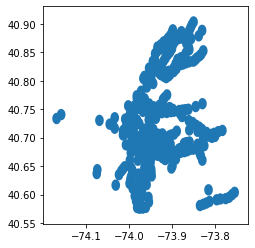

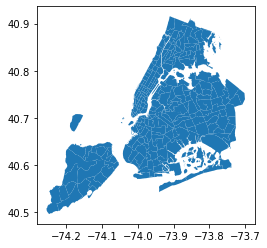

In [232]:
station_rides.plot()
taxi_zones.plot()

In [264]:
rides_geo = gpd.sjoin(taxi_zones, station_rides, how='left', op='intersects')

In [265]:
ridesbyzone = rides_geo.groupby('LocationID')[['2019_entries','2019_exits','2020_entries','2020_exits']].sum()

In [266]:
ridesbyzone['entries__pct_change'] = (ridesbyzone['2020_entries'] - ridesbyzone['2019_entries']) / (ridesbyzone['2019_entries'])
ridesbyzone['exits_pct_change'] = (ridesbyzone['2020_exits'] - ridesbyzone['2019_exits']) / (ridesbyzone['2019_exits'])


In [269]:
ridesbyzone = ridesbyzone.reset_index()

In [271]:
ridesbyzone.to_csv('ridership_by_taxizone.csv')